# Course 4 - Molecular Evolution

<div class="alert-success">
    <h3> The course covers following topics: </h3></br>
  Part 1 - Phylogenetic Tree Construction </br>
  4.1. Distance-based Phylogeny Construction </br> 
  4.2. Unweighted Pair Group Method with Arithmetic Mean (UPGMA) Phylogeny Construction </br>
  4.3. Neighbor-Joining Method Phylogeny Construction </br>   
  4.4. Character-based Phylogeny Construction (Maximum Parsimony) </br> </br>
  Part 2 - Peptide identification from Spectral Vectors </br>
  4.5. Ideal spectral vector to peptide </br>
  4.6. Real spectral vector to peptide 
</div>

## 4.1. Distance-based Phylogeny Consturction

In this section, we use the distances between leaves to construct an unrooted phylogenetic tree.  
The final goal is to perform the following task:  
* **Input**: n x n distance matrix between the leaves.
* **Output**: A weighted adjacency list for the simple tree fitting this matrix.

When the distance matrix is "additive", we can find a tree that perfectly fits the distance matrix.
* pick an arbitrary leaf j, compute LimbLength(j), and construct the distance matrix $D^{trimmed}$;
* solve the Distance-Based Phylogeny Problem for $D^{trimmed}$;
* identify the point in Tree($D^{trimmed}$) where leaf j should be attached in Tree($D$);
* add a limb of length LimbLength(j) growing from this attachment point in Tree($D^{trimmed}$) to form Tree($D$).

In [30]:
import numpy as np

def Distances(adjacency):
    m = np.shape(adjacency)[0]
    distances = adjacency
    distances[adjacency==0] = np.inf
    distances[np.diag_indices(m)] = 0
    for k in range(m):
        for i in range(m):
            for j in range(m):
                if (distances[i][k]<np.inf) and (distances[k][j]<np.inf) \
                and (distances[i][k] + distances[k][j] < distances[i][j]):
                    distances[i][j] = distances[i][k] + distances[k][j]
    return distances

def LimbLength(n,j,distances):
    dm = np.zeros((n,n))
    dm[dm==0] = np.inf
    for i in range(n):
        for k in range(n):
            if i!=j and k!=j:
                 dm[i,k] = (distances[i,j]+distances[j,k]-distances[i,k])/2
    return np.ndarray.min(dm)

def AddNode(T, pathEnds, Distances, d):
    n = np.shape(T)[0]
    begin, end = pathEnds    
    path = {} #distance:node
    for k in range(n):
        if Distances[begin,end] == Distances[begin,k]+Distances[k,end]:
            path[Distances[begin,k]] = k
    dlist = list(path.keys())
    dlist.sort()
    rn = [i>=d for i in dlist].index(1)
    if dlist[rn] == d:
        return path[d], T
    rightnode = path[dlist[rn]]
    leftnode = path[dlist[rn-1]]
    Tplus = np.zeros((n+1,n+1))
    Tplus[0:n,0:n] = T
    Tplus[n,leftnode], Tplus[leftnode,n] = d - dlist[rn-1], d - dlist[rn-1]
    Tplus[n,rightnode], Tplus[rightnode,n] = dlist[rn] - d, dlist[rn] - d
    Tplus[leftnode,rightnode], Tplus[rightnode,leftnode] = 0, 0
    return n, Tplus

In [ ]:
def AdditivePhylogeny(D):
    n = np.shape(D)[0]
    if n==2:
        return D    
    limbLength = LimbLength(n,n-1,D)
    D[n-1,0:n-1] -= limbLength
    D[0:n-1,n-1] -= limbLength
    Dred = np.copy(D)[0:n-1,0:n-1]
    T = AdditivePhylogeny(Dred)
    distances = Distances(np.copy(T))
    for i in range(n-1):
        for k in range(n-1):
            if D[i,n-1]+D[k,n-1] == distances[i,k]:
                pathEnds = (i,k)
    addedNode, T = AddNode(T, pathEnds, distances, D[i,n-1])
    T = np.insert(T,n-1,0,axis=0)
    T = np.insert(T,n-1,0,axis=1)
    T[addedNode+1,n-1], T[n-1,addedNode+1] = limbLength, limbLength    
    return T

Now we can use these functions to construct a phylogenetic tree, and then visualize using networkx package.

In [24]:
filename = 'Course4_Data/Input_Adjacency.txt'
adjacency = []
with open(filename,'r',encoding='utf-8') as file:
   n = int(file.readline().strip())
   f = file.readline().strip()
   while(f):
       adjacency.append([float(x) for x in f.split()])
       f = file.readline().strip()
adjacency = np.array(adjacency)
T = AdditivePhylogeny(adjacency)
m = np.shape(T)[0]

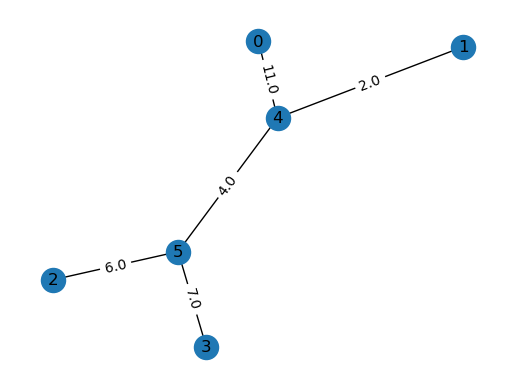

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(T)

edge_labels = {(i, j): T[i][j] for i, j in G.edges()}
nx.set_edge_attributes(G, edge_labels, 'weight')

pos = nx.spring_layout(G)

fig, ax = plt.subplots()
nx.draw(G, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## 4.2. Unweighted Pair Group Method with Arithmetic Mean (UPGMA) Phylogeny Construction

The above distance-based phylogeny construction algorithm only works when the distance matrix is additive. When it is not, we could try to find a Tree that best approximates the true distaince matrix according to least sum of squared errors. However, this problem is NP-Complete, so there is no fast algorithm for it.

Here, we use a different heuristic called UPGMA to construct a phylogenetic tree. The advantage of UPGMA is that it allows us to calculate the age of the common ancestors represented by the internal nodes.

* **Input**: n x n distance matrix.
* **Output**: An adjacency list for the ultrametric tree returned by UPGMA.

UPGMA is a hierarchical clustering method based on agglomeration. It involves the following steps:
* Initially, each leaf node is a separate cluster.
* While there are more than one cluster, two clusters that are the closest are identified and merged. The new node becomes the parent of the two initial clusters (nodes).
* The distance between the new cluster and the rest of the clusters are calculated.

The distance between two clusters $C_1$ and $C_2$ is calculated as $$D_{C_1,C_2} = \frac{∑_{i∈C_1}∑_{j∈C_2}D_{i,j}}{|C_1||C_2|}$$

In [68]:
def getNodeString(tree, node, n):
    if node < n:
        return [node]
    else:
        nodeString = []
        for x in tree[node]:
            if x < node:
                nodeString += getNodeString(tree, x, n)
        return nodeString
    
def JoinClusters(D, clusters, cluster_age, cluster_size, tree, num_nodes):
    new = max(tree.keys())+1
    n = np.shape(D)[0]
    i,j = np.argmin(D)//n, np.argmin(D)%n
    node1, node2 = clusters[i], clusters[j]
    nodes_to_cluster = getNodeString(tree,node1,num_nodes)+getNodeString(tree,node2,num_nodes)
    #print(' '.join([str(x+1) for x in nodes_to_cluster]))
    newage = D[i,j]/2
    Dnewk = [(D[i,k]*cluster_size[node1]+D[j,k]*cluster_size[node2])/(cluster_size[node1] \
             +cluster_size[node2]) for k in np.setdiff1d(list(range(n)),[i,j])]
    i,j = max(i,j),min(i,j)
    clusters = np.delete(clusters,i)
    clusters = np.delete(clusters,j)
    clusters = np.append(clusters,new)
    cluster_age[new] = newage
    cluster_size[new] = cluster_size[node1]+cluster_size[node2]
    tree[new] = [node1,node2]
    tree[node1] = tree[node1]+[new]
    tree[node2] = tree[node2]+[new]
    D = np.delete(D,i,axis=0)
    D = np.delete(D,i,axis=1)
    D = np.delete(D,j,axis=0)
    D = np.delete(D,j,axis=1)
    if np.shape(D)[0]>0:
        D = np.insert(D,n-2,Dnewk,axis=0)
        D = np.insert(D,n-2,Dnewk+[np.inf],axis=1)
    return D, clusters, cluster_age, cluster_size, tree


def UPGMA(D,n):
    clusters = np.arange(n)
    tree = {k:[] for k in range(n)}
    cluster_age = {k:0 for k in range(n)}
    cluster_size = {k:1 for k in range(n)}
    while len(clusters)>1:
        D, clusters, cluster_age, cluster_size, tree = JoinClusters(D, clusters, cluster_age, cluster_size, tree, n) 
        
    T = np.zeros((len(tree.keys()),len(tree.keys())))
    for node in tree.keys():
        for neighbor in tree[node]:
            T[node,neighbor] = abs(cluster_age[node]-cluster_age[neighbor])
    return tree, T

In [71]:
filename = 'Course4_Data/Input_UPGMA.txt'
adjacency = []
with open(filename,'r',encoding='utf-8') as file:
   n = int(file.readline().strip())
   f = file.readline().strip()
   while(f):
       adjacency.append([float(x) for x in f.split()])
       f = file.readline().strip()
adjacency = np.array(adjacency)
n = np.shape(adjacency)[0]
for i in range(n):
    adjacency[i,i] = np.inf

#tree = NeighborJoining(adjacency, list(range(n)))
tree, T = UPGMA(adjacency, n)
for node in sorted(tree.keys()):
    for neighbor in tree[node]:
        print('{:d}->{:d}:{:.3f}'.format(node,neighbor,T[node][neighbor]))

0->5:7.000
1->6:8.833
2->4:5.000
3->4:5.000
4->2:5.000
4->3:5.000
4->5:2.000
5->0:7.000
5->4:2.000
5->6:1.833
6->1:8.833
6->5:1.833


## 4.3. Neighbor-Joining Method Phylogeny Construction

To perform this task, we use the following algorithm:
* find a pair of neighboring leaves *i* and *j*;
* replace *i* and *j* with their parent, and recompute the distances from this parent to all other leaves as described above;
* solve the Distance-Based Phylogeny problem for the smaller tree;
* add the previously removed leaves *i* and *j* back to the tree.

In [72]:
def NeighborJoiningMatrix(D):
    n = np.shape(D)[0]
    Dstar = (n-2)*D
    Totaldistance = [np.sum(D[i]) for i in range(n)]
    for i in range(n):
        for j in range(n):
            Dstar[i,j] = Dstar[i,j] - Totaldistance[i] - Totaldistance[j]
    return Dstar

def JoinNeighbors(D, nodes):
    new = max(nodes)+1
    Dstar = NeighborJoiningMatrix(D)
    n = len(nodes)
    Totaldistance = [np.sum(D[i]) for i in range(n)]
    for s in range(n):
        Dstar[s,s] = np.infty
    i,j = np.argmin(Dstar)//n, np.argmin(Dstar)%n
    i,j = max(i,j), min(i,j)
    for s in range(n):
        Dstar[s,s] = 0
    Delta = (Totaldistance[i] - Totaldistance[j])/(n-2)
    limblengths = [(1/2)*(D[i,j]+Delta), (1/2)*(D[i,j]-Delta)]
    neighbors = [nodes[i], nodes[j]]
    Dnewk = [(D[i,k]+D[j,k]-D[i,j])/2 for k in np.setdiff1d(list(range(n)), [i,j])]
    nodes.pop(i)
    nodes.pop(j)
    D = np.delete(D,i,axis=0)
    D = np.delete(D,i,axis=1)
    D = np.delete(D,j,axis=0)
    D = np.delete(D,j,axis=1)    
    nodes.append(new)
    D = np.insert(D,n-2,Dnewk,axis=0)
    D = np.insert(D,n-2,Dnewk+[0],axis=1)
    attachment = new
    return neighbors, attachment, limblengths, D, nodes

def NeighborJoining(D, nodes):
    if len(nodes)==2:
        tree = {nodes[0]:[(nodes[1],D[0,1])], nodes[1]:[(nodes[0],D[1,0])]}
    elif len(nodes)>2:
        neighbors, attachment, limblengths, D, nodes = JoinNeighbors(D, nodes)
        tree = NeighborJoining(D, nodes)
        tree[neighbors[0]] = [(attachment, limblengths[0])]
        tree[neighbors[1]] = [(attachment, limblengths[1])]
        tree[attachment].append((neighbors[0],limblengths[0]))
        tree[attachment].append((neighbors[1],limblengths[1]))
    return tree

In [77]:
filename = 'Course4_Data/Input_Neighbor_joining.txt'
adjacency = []
with open(filename,'r',encoding='utf-8') as file:
   n = int(file.readline().strip())
   f = file.readline().strip()
   while(f):
       adjacency.append([float(x) for x in f.split()])
       f = file.readline().strip()
adjacency = np.array(adjacency)
n = np.shape(adjacency)[0]
tree = NeighborJoining(adjacency, list(range(n)))
for node in sorted(tree.keys()):
    for neighbor in tree[node]:
        print('{:d}->{:d}:{:.3f}'.format(node,neighbor[0],neighbor[1]))

0->4:8.000
1->5:13.500
2->5:16.500
3->4:12.000
4->5:2.000
4->3:12.000
4->0:8.000
5->4:2.000
5->2:16.500
5->1:13.500


## 4.4. Character-based Phylogeny Construction (Maximum Parsimony)

### Motivation
A limitation of the distance-based phylogeny construction methods that we have seen so far is that we lose information about the actual underlying traits (e.g. sequences) that give rise to the distances. Thus, while we can calculate the distances from the leaves (current species) to the internal nodes (common ancestors), we cannot say anything about the traits of the internal nodes.  
In this section, we construct character-based phylogenetic trees. Instead of calculating the distances among the species, we directly use the sequence information. The problem can be broken down into two steps:  
(1) Identifying the structure of the tree.  
(2) Identifying the most parsimonious labeling of the internal nodes.  

We start by assuming that the tree structure is known and solving the easier problem of labeling the internal nodes. We call this the small parsimony problem.

### Small Parsimony Problem
Find the most parsimonious labeling of the internal nodes of a rooted tree.

* **Input**: A rooted binary tree with each leaf labeled by a string of length m.
* **Output**: A labeling of all other nodes of the tree by strings of length m that minimizes the parsimony score of the tree.